In [2]:
%load_ext autoreload

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
from tqdm import tqdm,tqdm_notebook
%matplotlib inline

import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.join(os.path.abspath(''),'..','scripts'))
sys.path.append(os.path.join(os.path.abspath(''),'..','src'))

sns.set_style("whitegrid")
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from Generator import *
from RobustWrapper import *
from Simulator import *
from NetShieldSolver import *
from DegreeSolver import *
from RandomSolver import *
%autoreload 2

# Laplacian Study
Laplacian matrix may provide a scalable approach to both robust influence maximization and topology consolidation. In this experiment we compare seeds that are selected by the IMM algorithm to seeds that maximize $\mathbb{E}[\xi]$ of a possible world scenario. 

Let us consider a small BA graph with powerlaw distribution, with small probability values of 0.2.

In [262]:
# graph_params = {
#     'graph_type': 'powerlaw_cluster',
#     'random_weight': 0,
#     'both_directions': 1,
#     'weight_scale': 0.1,
#     'n': 1000,
#     'm': 10,
#     'p': 0.2
# }
graph_params = {
    "graph_type": "powerlaw_cluster",
    "weight_scale": 0.1,
    "both_directions": 1,
    "random_weight": 1,
    "n": 1000,
    "p": 0.4,
    "m": 2
}



In [263]:
G = Generator(graph_params).get()

Below, we see the spectrum of Laplacian matrix. The spectrum follows powerlaw distribution as well, therefore significant fraction may be pruned (as future work).

In [264]:
L_spect = nx.laplacian_spectrum(G.to_undirected())

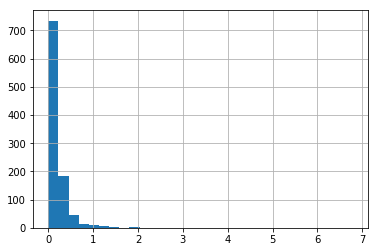

In [265]:
a = pd.Series(L_spect).hist(bins=30)

In [266]:
number_of_seeds = 5

Now we run two algorithms to find 3 seeds. Although we select a small number of seeds, due to the type of the graph, they active more than 70\% of the graph.

In [267]:
result = {}
result["imm"] = RobustWrapper.run_imm(G, epsilon=0.1, number_of_seeds=number_of_seeds*2, reward_type=0)

########## Step1 ########## 
build_hyper_graph_r R=12626 
Collected  seedSet.size()=10  optimal seeds 
x=1 estimate_influence=39.9145 ept=0.0399145 g.n=1000 
build_hyper_graph_r R=25253 
Collected  seedSet.size()=10  optimal seeds 
x=2 estimate_influence=37.895 ept=0.037895 g.n=1000 
build_hyper_graph_r R=50507 
Collected  seedSet.size()=10  optimal seeds 
x=3 estimate_influence=37.598 ept=0.037598 g.n=1000 
build_hyper_graph_r R=101015 
Collected  seedSet.size()=10  optimal seeds 
x=4 estimate_influence=37.0238 ept=0.0370238 g.n=1000 
build_hyper_graph_r R=202031 
Collected  seedSet.size()=10  optimal seeds 
x=5 estimate_influence=36.7071 ept=0.0367071 g.n=1000 
########## Step2 ########## 
opt_lower_bound=32.1591 
R=17567 
build_hyper_graph_r R=17567 
step2 finish 
Collected  seedSet.size()=10  optimal seeds 
Imm Seeds calculated 
Done. 


In [268]:
result['lapl'] = RobustWrapper.run_imm(G, epsilon=0.1, number_of_seeds=number_of_seeds*2, reward_type=1)

build_hyper_graph_r R=10000 
Collected  seedSet.size()=10  optimal seeds 
Imm Seeds calculated 
Done. 


In [269]:
advs = {}

K = 5

ns_s = NetShieldSolver(G,k=K)
ns_s.run()
advs["NetShield"] = ns_s.log["Blocked nodes"]

deg_s = DegreeSolver(G,k=K)
deg_s.run()
advs["Degree"] = deg_s.log["Blocked nodes"]


rn_s = RandomSolver(G,k=K)
rn_s.run()
advs["Random"] = rn_s.log["Blocked nodes"]

In [ ]:
RobustWrapper.run_singlegreedy(G, epsilon=0.2, number_of_seeds=number_of_seeds, blocked_dic_of_nodes=advs, beta=0.5, gamma=0.5)

In [ ]:
RobustWrapper.run_singlegreedy(G, epsilon=0.15,
                               number_of_seeds=number_of_seeds,
                               blocked_dic_of_nodes=advs, beta=1, gamma=0.001)

By running simulations, we observe that IMM gives a bit better result of the expected spread in the unblocked graph.

In [275]:
r = try_blocked(G, result['imm']['imm']['seeds'], advs) # changed, moved to Simulator
r

10
NetShield 6
Degree 3
Random 3
0 blocked are seeds
Collected  seeds.size()=3  seeds 
7.8273, 3.06109
Done. 
0 blocked are seeds
Collected  seeds.size()=3  seeds 
7.4012, 2.65233
Done. 
0 blocked are seeds
Collected  seeds.size()=3  seeds 
8.2192, 4.01858
Done. 


0.0074012

In [276]:
r = try_blocked(G, result['lapl']['imm']['seeds'], advs)
r

10
NetShield 9
Degree 8
Random 8
0 blocked are seeds
Collected  seeds.size()=5  seeds 
9.9676, 3.33655
Done. 
0 blocked are seeds
Collected  seeds.size()=5  seeds 
9.0212, 2.56257
Done. 
0 blocked are seeds
Collected  seeds.size()=5  seeds 
10.6322, 4.19592
Done. 


0.0090212

# Correlation of the largest component with spread

In this experiment I study the correlation between metric based on the expected largest component size (ROB), and the expected spread under IC in directed and undirected graphs.

First, I study the relation between the size of the largest component if nodes are immunized in expectation, or after graph sampling. I show that the best seed-oblivious immunization technique (NetShield) applied to stochastic graph leads to a much smaller largest component than naive degree heuristic applied for each graph sample (a posteriori immunization). Furthermore, the a posteriori immunization is more sensitive to the number of influenced nodes, and converges to 0 within first 20% of nodes, while the a priori immunization does not converge to 0. This result highlihgts the importance of the fact, that if ROB is based on a posteriori immunization. Since the size of the behavior of the largest component differs so much between there two immunization types, it is unlikely that measurement based on one type will correlate with the objective based on another type.

Second, I study the relation of the largest component of directed/undirected graph and the expected spread under IC model in *unblocked* graph. I show that for undirected graph these two measures are close, although not the same. But for directed graph, weakly and strongly connected component sizes differs significantly from the expected spread. The best measure for the directed graph is the maximum size of a tree, which is smaller than the size of the weakly connected component. This result shows that using connected components for directed graphs is probably not a good idea.

Third, I study the correlation between the expected spread and ROB. Results show that ROB is better correlated with expected spread in unblocked graph, then with the worst-case expected spread of SatGreedy in blocked graph.

### A priori vs A Posteriori Immunization
First, we want to compare the size of the largest component with immunization after sampling and before sampling.

In [16]:
# this defines input
graph_params = {
    "graph_type": "powerlaw_cluster",
    "weight_scale": 0.1,
    "both_directions": 1,
    "random_weight": 0,
    "n": 1000,
    "p": 0.4,
    "m": 2
}
GG = Generator(graph_params).get().to_undirected()

In [32]:
# this gives us the best immunized nodes
nss = NetShieldSolver(GG,k=len(G))
nss.run()

In [207]:
def get_mcsim_robust(G):
    '''
    This function calculates the robustness as sum of largest component sizes, averaged over MC iterations
    '''
    s = defaultdict(lambda: [])
    for mc_it in tqdm_notebook(range(10)):
        edges = [(e[0],e[1]) for e in G.edges(data=True) if e[2]['weight'] > np.random.random()]
        G2 = G.edge_subgraph(edges).copy()
        for i in range(len(G2)-1):
            centrality = dict(G2.degree()) # nx.betweenness_centrality(GG)
            worst_node = pd.Series(centrality).idxmax()
            G2.remove_node(worst_node)
            s[i].append(len(max(nx.connected_component_subgraphs(G2), key=len)))
    return s

In [26]:
s = get_mcsim_robust(GG)

Text(0, 0.5, 'robustness E[S(Q)]')

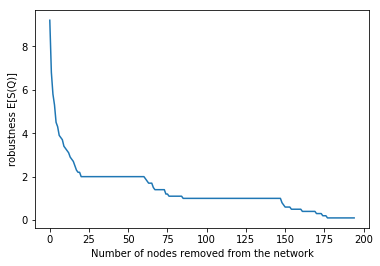

In [35]:
stats = [sum(s[ss]) for ss in s]
plt.plot(np.array(stats)/10)
plt.xlabel("Number of nodes removed from the network")
plt.ylabel("robustness E[S(Q)]")

In [76]:
best_seed = RobustWrapper.run_imm(GG, epsilon=0.3, number_of_seeds=10, reward_type=0, verbose=False)['imm']['seeds']

In [90]:
def get_infl_max_ser(G):
    s = []
    for bl_iter in tqdm_notebook(range(200)):
        sim = Simulator(GG, best_seed, 'C', blockable_seeds=True, number_of_seeds=-1)
        sim.add_blocked('netshield', nss.log['Blocked nodes'][:bl_iter])
        s.append(sim.run(100)['netshield']['mc_objective'])
    return s

In [91]:
s = get_infl_max_ser(G)

Text(0, 0.5, 'I(S) for IM seed and static NetShield')

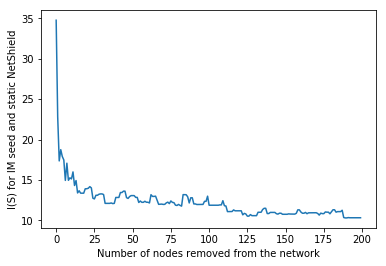

In [93]:
plt.plot(np.array(s))
plt.xlabel("Number of nodes removed from the network")
plt.ylabel("I(S) for IM seed and static NetShield")

We see that size of the network immunized after sampling is much smaller, then the network immunized in expectation. This is because latter is seed oblivious, and for small probabilities sampled networks often do not reached immunized nodes, as we see on the picture above. The line converges to 0 much slower than for posteriori immunization.

### Correlation with the largest component size
Here we compare size of the expected largest component and size of spread of a single seed, with no immunized nodes.


In [242]:
# directed case
graph_params = {
    "graph_type": "powerlaw_cluster",
    "weight_scale": 0.1,
    "both_directions": 0,
    "random_weight": 0,
    "n": 1000,
    "p": 0.4,
    "m": 2
}
G = Generator(graph_params).get()
# Undirected case is when there are both directions with the same probabilities. If one succeed, another does not matter. If one does not succeed, another also does not matter because another will try to succeed only if another node is activated, but then they both are activated. It is not clear though if the possible world semantics hold.

In [103]:
# strongly connected component
s = []
for i in tqdm_notebook(range(100)):
    edges = [(e[0],e[1]) for e in G.edges(data=True) if e[2]['weight'] > np.random.random()]
    G2 = G.edge_subgraph(edges).copy()
    s.append(len(max(nx.strongly_connected_component_subgraphs(G2), key=len)))

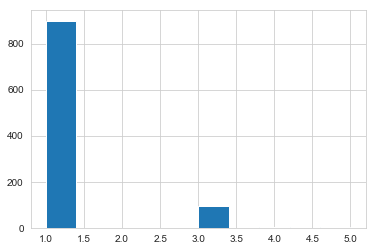

In [108]:
pd.Series(s).hist()

The picture shows the distribution of the size of largest strongly connected component. The distribution is due MC simulations. Strong component is very small.

In [109]:
# weakly connected component
s = []
for i in tqdm_notebook(range(100)):
    edges = [(e[0],e[1]) for e in G.edges(data=True) if e[2]['weight'] > np.random.random()]
    G2 = G.edge_subgraph(edges).copy()
    s.append(len(max(nx.weakly_connected_component_subgraphs(G2), key=len)))

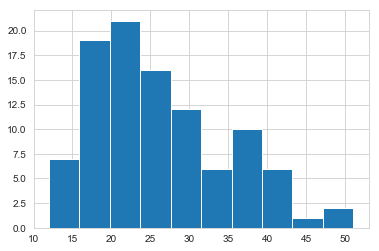

In [110]:
pd.Series(s).hist()

This is the size of the largest weakly connected component.  The distribution is due MC simulations.

In [120]:
# compare with expected influence
r = RobustWrapper.run_imm(GG, epsilon=0.15, number_of_seeds=1, reward_type=0, verbose=False)
best_seed = r['imm']['seeds']
sim = Simulator(GG, best_seed, 'C', blockable_seeds=True, number_of_seeds=-1)
sim.run(100), "RR objective {}".format(r['imm']['objective'])

({'iterations': 100, 'mc_objective': 9.01, 'mc_objective_std': 3.86392},
 'RR objective 8.53013362421598')

We have very strange result: the largest weakly connected component is significantly larger than the expected spread of size 9

In order to verify the result, we calculate participation of each node in the largest component over iterations.

In [121]:
participation = defaultdict(lambda: 0)
for i in tqdm_notebook(range(100)):
    edges = [(e[0],e[1]) for e in G.edges(data=True) if e[2]['weight'] > np.random.random()]
    G2 = G.edge_subgraph(edges).copy()
    max_subgraph = max(nx.weakly_connected_component_subgraphs(G2), key=len)
    for n in max_subgraph:
        participation[n] += 1

In [123]:
pd.Series([participation[n]/100 for n in participation]).value_counts()

0.01    197
0.02    129
0.03     87
0.04     56
0.05     53
0.06     43
0.07     29
0.08     19
0.09     17
0.11     12
0.12      9
0.10      8
0.13      7
0.15      3
0.16      2
0.21      1
0.14      1
0.39      1
0.18      1
0.60      1
0.24      1
0.35      1
dtype: int64

Most of nodes participate in the largest component in less than 1% of cases. However, there is one node that belongs to largest component in 60% of cases.

In [126]:
[n for n in participation if participation[n]/100 > 0.5], best_seed

([2], [1])

Surprisingly, that is not the best seed found by TIM.

In [129]:
participation[best_seed[0]]/100

0.35

The best seed is second largest, with the score 35%. But even 35% is too small, meaning that in majority of cases the seed does not belong to the largest weakly connected component.

Let us check if the second node might be a better seed.



In [132]:
sim = Simulator(GG, [2], 'C', blockable_seeds=True, number_of_seeds=-1)
sim.run(1000)

{'iterations': 1000, 'mc_objective': 5.306, 'mc_objective_std': 2.45772}

Surprisingly, despite the fact the the node participates in twice larger number of weakly connected components, the expected spread is almost twice smaller (5 to 9). One reason may be that due to the nature of influence spread, the size of spanning trees is what matters. 

Let us calculate the size of maximum spanning tree across iterations.

In [146]:
# size of branching in the weakly connected component
s = []
for i in tqdm_notebook(range(100)):
    edges = [(e[0],e[1]) for e in G.edges(data=True) if e[2]['weight'] > np.random.random()]
    G2 = G.edge_subgraph(edges).copy()
    a = max([len(nx.descendants(G2, n)) for n in G2.nodes()])
    s.append(a)

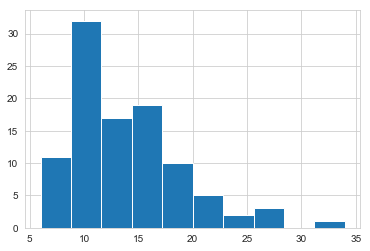

In [147]:
pd.Series(s).hist()

This is the size of the largest tree in a graph.  The distribution is due MC simulations. This is a bit better than for weakly and strongly conected components, but the average size is still larger than the best expected spread (9).

Now, let us check the size of the largest component of *undirected* network. Let us compare the size of the largest component.

In [149]:
graph_params = {
    "graph_type": "powerlaw_cluster",
    "weight_scale": 0.1,
    "both_directions": 1,
    "random_weight": 0,
    "n": 1000,
    "p": 0.4,
    "m": 2
}
G_both_directions = Generator(graph_params).get()

In [156]:
# get the IC spread
r = RobustWrapper.run_imm(G_both_directions, epsilon=0.15, number_of_seeds=1, reward_type=0, verbose=False)
best_seed = r['imm']['seeds']
sim = Simulator(G_both_directions, best_seed, 'C', blockable_seeds=True, number_of_seeds=-1)
sim.run(10000), "RR objective {}".format(r['imm']['objective'])

({'iterations': 10000, 'mc_objective': 17.7199, 'mc_objective_std': 11.0411},
 'RR objective 18.041799380426717')

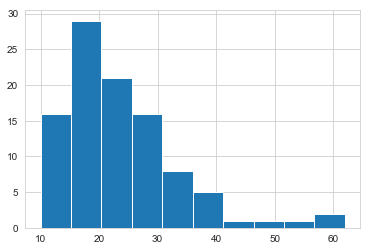

In [163]:
# get the largest component
G3 = G_both_directions.to_undirected()
p = 0.1
s = []
for i in tqdm_notebook(range(100)):
    edges = [(e[0],e[1]) for e in G3.edges(data=True) if p > np.random.random()]
    G4 = G3.edge_subgraph(edges).copy()
    s.append(len(max(nx.connected_component_subgraphs(G4), key=len)))
pd.Series(s).hist()

In [166]:
pd.Series(s).describe()

count    100.000000
mean      23.870000
std        9.910361
min       10.000000
25%       17.000000
50%       22.000000
75%       27.000000
max       62.000000
dtype: float64

We see that expected spread (18) is a bit smaller than the mean of the largest component (23)

### Correlation for the robust IM
Here we check the correlation of ROB with expected spread in unblocked and blocked networks, for different uniform influence probabilities p.

In [205]:
# consider undirected graph as simplier case
graph_params = {
    "graph_type": "powerlaw_cluster",
    "weight_scale": 0.1,
    "both_directions": 1,
    "random_weight": 0,
    "n": 1000,
    "p": 0.4,
    "m": 2
}
G_both_directions = Generator(graph_params).get()
G_undirected = G_both_directions.to_undirected()

In [208]:
# first consider the size of the largest component, and sum it over all blocked nodes
s = get_mcsim_robust(G_undirected)

Text(0, 0.5, 'robustness E[S(Q)]')

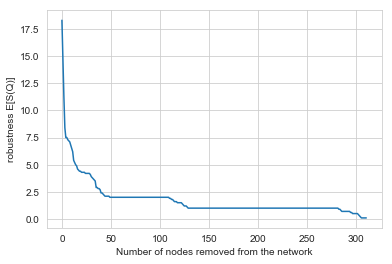

In [209]:
stats = [sum(s[ss]) for ss in s]
plt.plot(np.array(stats)/10)
plt.xlabel("Number of nodes removed from the network")
plt.ylabel("robustness E[S(Q)]")

In [210]:
sb = np.sum(np.array([sum(s[ss]) for ss in s])/10)

In [211]:
sb

561.3

In [177]:
# next consider the IC model
r = RobustWrapper.run_imm(G_both_directions, epsilon=0.15, number_of_seeds=1, reward_type=0, verbose=False)
best_seed = r['imm']['seeds']
sim = Simulator(G_both_directions, best_seed, 'C', blockable_seeds=True, number_of_seeds=-1)
sim.run(10000), "RR objective {}".format(r['imm']['objective'])

({'iterations': 10000, 'mc_objective': 24.2704, 'mc_objective_std': 11.6356},
 'RR objective 24.084820454644618')

In [222]:
best_seed

[1]

In [ ]:
# and let us also add robustness objective, the expected size with adversaries
advs = {}

K = 5

ns_s = NetShieldSolver(G_both_directions,k=K)
ns_s.run()
advs["NetShield"] = ns_s.log["Blocked nodes"]

deg_s = DegreeSolver(G,k=K)
deg_s.run()
advs["Degree"] = deg_s.log["Blocked nodes"]


rn_s = RandomSolver(G,k=K)
rn_s.run()
advs["Random"] = rn_s.log["Blocked nodes"]


single_greedy_result = RobustWrapper.run_singlegreedy(G_both_directions, epsilon=0.15,
                                                       number_of_seeds=1,
                                                       blocked_dic_of_nodes=advs, beta=1, gamma=0.001, verbose=True)

In [221]:
single_greedy_result

{'adversaries_size': 3,
 'all_greedy': {'mc_obj': 0.006647,
  'mc_obj_std': 0.0037942576349004114,
  'mc_simulation_time': 0.013658,
  'objective': 0.006907497257500259,
  'seeds': [17],
  'time': 18.627291,
  'worst_adv_name': 'Degree'},
 'beta': 1.0,
 'gamma': 0.001,
 'graph_id': '317206540848318269362272630060737833887',
 'imm': {'seeds': None},
 'rr_collection_time': 9.310198999999999,
 'rr_opt_time': 9.313942,
 'satgreedy': {'mc_obj': 0.006883,
  'mc_obj_std': 0.003915777189779828,
  'mc_simulation_time': 0.013526,
  'objective': 0.006907497257500259,
  'seeds': [17],
  'time': 10.150711,
  'worst_adv_name': 'Degree'},
 'single_greedy': {'mc_obj': 0.006692999999999999,
  'mc_obj_std': 0.003754297670670236,
  'mc_simulation_time': 0.01222,
  'objective': 0.006907497257500259,
  'seeds': [17],
  'time': 9.371343999999999,
  'worst_adv_name': 'Degree'},
 'single_greedy_celf': {'mc_obj': 0.006745,
  'mc_obj_std': 0.003752862241010185,
  'mc_simulation_time': 0.013541,
  'objective': 0

In [236]:
results = []
for p in tqdm_notebook(np.arange(0.01,0.3,0.03)):
    nx.set_edge_attributes(G_both_directions,p,"weight")
    nx.set_edge_attributes(G_undirected,p,"weight")
    
    s = get_mcsim_robust(G_undirected)
    sb = np.sum(np.array([sum(s[ss]) for ss in s])/10)
    
    r = RobustWrapper.run_imm(G_both_directions, epsilon=0.3, number_of_seeds=1, reward_type=0, verbose=False)
    best_seed = r['imm']['seeds']
    sim = Simulator(G_both_directions, best_seed, 'C', blockable_seeds=True, number_of_seeds=-1)
    lc = sim.run(1000)['mc_objective']
    
    print("imm done")
    
    # single greedy
    advs = {}
    K = 10

    ns_s = NetShieldSolver(G_both_directions,k=K)
    ns_s.run()
    advs["NetShield"] = ns_s.log["Blocked nodes"]

    deg_s = DegreeSolver(G,k=K)
    deg_s.run()
    advs["Degree"] = deg_s.log["Blocked nodes"]

    rn_s = RandomSolver(G,k=K)
    rn_s.run()
    advs["Random"] = rn_s.log["Blocked nodes"]
    
    print("adv done")

    single_greedy_result = RobustWrapper.run_singlegreedy(G_both_directions, epsilon=0.2,
                                                           number_of_seeds=1,
                                                           blocked_dic_of_nodes=advs, beta=1, gamma=0.01, verbose=False)
    
    results.append((p, sb, lc, single_greedy_result['satgreedy']['objective']))

imm done
adv done


imm done
adv done


imm done
adv done


imm done
adv done


imm done
adv done


imm done
adv done


imm done
adv done


imm done
adv done


imm done
adv done


imm done
adv done


In [239]:
results = np.array(results)
df = pd.DataFrame({'p': results[:,0], "ROB": results[:,1], "TIM": results[:,2], "SatGreedy": results[:,3]})

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


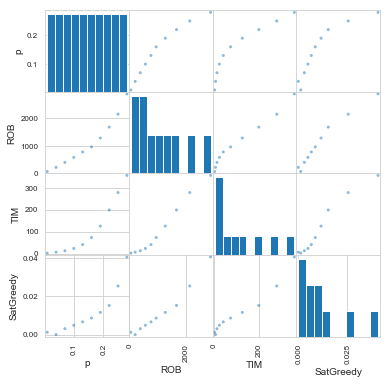

In [240]:
pd.scatter_matrix(df, figsize=(6, 6))
plt.show()

The picture above shows a correlation matrix between ROB, TIM, SatGreedy and influence probabilities p. Diagonal shows the histogram of values.

In [241]:
df.corr()

,p,ROB,TIM,SatGreedy
p,1.000000,0.963571,0.927082,0.893007
ROB,0.963571,1.000000,0.988127,0.977910
TIM,0.927082,0.988127,1.000000,0.975911
SatGreedy,0.893007,0.977910,0.975911,1.000000


We see that although on the picture it seems like SatGreedy is better aligned with ROB, the correlation matrix says that the highest correlation is between ROB and TIM. That means our robustness measure better predicts spread for unblocked graph, rather that with few blocked nodes.

# New experiments on R

Text(0, 0.5, 'E[s(Q)]')

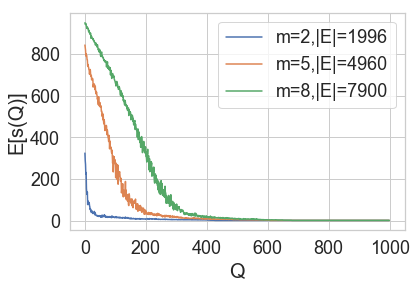

In [55]:
for m in tqdm_notebook(range(2,10,3)):
    graph_params = {
        "graph_type": "powerlaw_cluster",
        "weight_scale": 0.5,
        "both_directions": 0,
        "random_weight": 0,
        "n": 1000,
        "p": 0.4,
        "m": m
    }
    G = Generator(graph_params).get()

    ns_s = NetShieldSolver(G,k=len(G)) # TODO NetShield is for directed or not
    ns_s.run()
    all_Q = ns_s.log["Blocked nodes"]

    r = RobustWrapper.run_rob(G, all_Q, 5)

    plt.plot(r['sequence'], label="m={},|E|={}".format(m,G.number_of_edges()))
plt.legend()
plt.xlabel("Q")
plt.ylabel("E[s(Q)]")

Text(0, 0.5, 'E[s(Q)]')

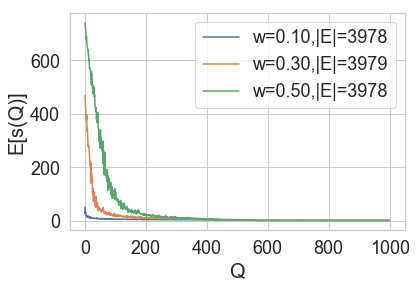

In [63]:
for p in tqdm_notebook(np.arange(0.1,0.6,0.2)):
    graph_params = {
        "graph_type": "powerlaw_cluster",
        "weight_scale": p,
        "both_directions": 0,
        "random_weight": 0,
        "n": 1000,
        "p": 0.4,
        "m": 4
    }
    G = Generator(graph_params).get()

    ns_s = NetShieldSolver(G,k=len(G)) # TODO NetShield is for directed or not
    ns_s.run()
    all_Q = ns_s.log["Blocked nodes"]

    r = RobustWrapper.run_rob(G, all_Q, 5)

    plt.plot(r['sequence'], label="w={:0.2f},|E|={}".format(p,G.number_of_edges()))
plt.legend()
plt.xlabel("Q")
plt.ylabel("E[s(Q)]")

Text(0, 0.5, 'E[s(Q)]')

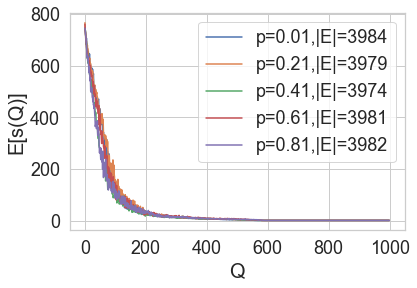

In [64]:
for p in tqdm_notebook(np.arange(0.01,0.99,0.2)):
    graph_params = {
        "graph_type": "powerlaw_cluster",
        "weight_scale": 0.5,
        "both_directions": 0,
        "random_weight": 0,
        "n": 1000,
        "p": p,
        "m": 4
    }
    G = Generator(graph_params).get()

    ns_s = NetShieldSolver(G,k=len(G)) # TODO NetShield is for directed or not
    ns_s.run()
    all_Q = ns_s.log["Blocked nodes"]

    r = RobustWrapper.run_rob(G, all_Q, 5)

    plt.plot(r['sequence'], label="p={:0.2f},|E|={}".format(p,G.number_of_edges()))
plt.legend()
plt.xlabel("Q")
plt.ylabel("E[s(Q)]")

In [ ]:
# scalability experiment
results = pd.DataFrame()
for mode in tqdm_notebook([2,3,4,5],desc="mode"):
    for n in tqdm_notebook(range(100,1000,200)):
        graph_params = {
          "graph_type": "gaussian_random_partition",
          "weight_scale": 0.999,
          "random_weight": 0,
          "n": n,
          "s": 15,
          "v": 0.3,
          "p_in": 0.01,
          "p_out": 0.001
        }
        G = Generator(graph_params).get()

        ns_s = NetShieldSolver(G,k=len(G)) # TODO NetShield is for directed or not
        ns_s.run()
        all_Q = ns_s.log["Blocked nodes"]

        r = RobustWrapper.run_rob(G, all_Q, 10, mode=mode, verbose=True)
        r['n'] = n
        r['mode'] = mode
        results = results.append(r, ignore_index=True)

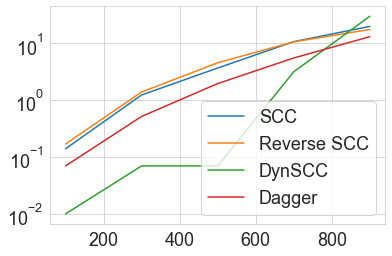

In [13]:
lmap = {1:"DFS", 2:"SCC", 3:"Reverse SCC", 4:"DynSCC", 5:"Dagger"}
for mode in [2,3,4,5]:
    plt.semilogy(results[results['mode'] == mode]["n"], 
             results[results['mode'] == mode]["runtime"]/(10**9),label=lmap[mode])
plt.legend()

In [10]:
results

,adversary file,dag traversal,mode,n,rob,runtime,sequence
0,/Users/au624601/PhD/data/irim/tmpForWrapper/ad...,0.0,2.0,100.0,4.200000,1.400000e+08,"[130, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, ..."
1,/Users/au624601/PhD/data/irim/tmpForWrapper/ad...,0.0,2.0,200.0,5.492500,5.800000e+08,"[250, 240, 240, 240, 235, 240, 210, 210, 210, ..."
2,/Users/au624601/PhD/data/irim/tmpForWrapper/ad...,0.0,2.0,300.0,12.834000,1.400000e+09,"[1260, 1190, 1090, 1019, 990, 870, 780, 780, 6..."
3,/Users/au624601/PhD/data/irim/tmpForWrapper/ad...,0.0,2.0,400.0,7.390000,2.140000e+09,"[620, 540, 520, 520, 460, 320, 320, 320, 320, ..."
4,/Users/au624601/PhD/data/irim/tmpForWrapper/ad...,0.0,3.0,100.0,3.330000,1.700000e+08,"[150, 150, 110, 110, 110, 110, 110, 90, 60, 60..."
5,/Users/au624601/PhD/data/irim/tmpForWrapper/ad...,0.0,3.0,200.0,3.735000,6.000000e+08,"[230, 110, 110, 110, 110, 110, 110, 110, 110, ..."
6,/Users/au624601/PhD/data/irim/tmpForWrapper/ad...,0.0,3.0,300.0,6.318667,1.530000e+09,"[200, 200, 200, 200, 200, 200, 200, 200, 200, ..."
7,/Users/au624601/PhD/data/irim/tmpForWrapper/ad...,0.0,3.0,400.0,17.442750,2.780000e+09,"[810, 810, 1380, 1250, 1250, 1210, 1210, 1210,..."
8,/Users/au624601/PhD/data/irim/tmpForWrapper/ad...,0.0,4.0,100.0,4.920000,1.000000e+07,"[380, 330, 260, 210, 200, 200, 180, 120, 120, ..."
9,/Users/au624601/PhD/data/irim/tmpForWrapper/ad...,0.0,4.0,200.0,7.395000,3.000000e+07,"[600, 560, 490, 420, 420, 380, 380, 380, 380, ..."


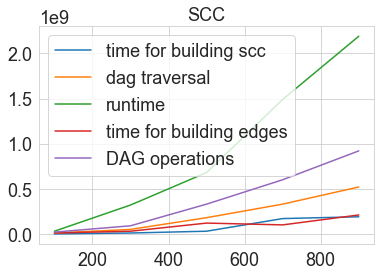

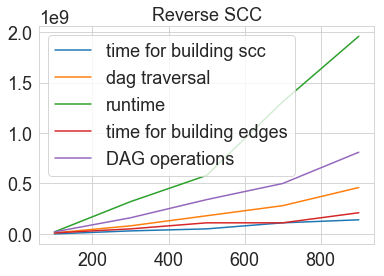

In [171]:
results["DAG operations"] = results['time for building scc'] + results["dag traversal"] + results['time for building edges']
fields = ['time for building scc', "dag traversal", 'runtime', 'time for building edges',"DAG operations"]
for mode in [2,3]:
    for f in fields:
        plt.plot(results[results['mode'] == mode]["n"], results[results['mode'] == mode][f],label=f)
    plt.legend()
    plt.title(lmap[mode])
    plt.show()

Text(0, 0.5, 'E[s(Q)]')

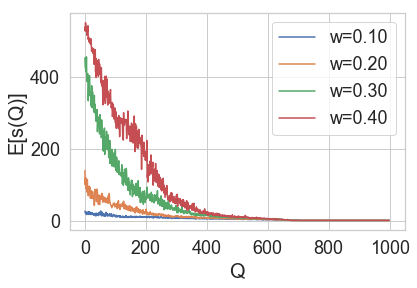

In [97]:
for w in tqdm_notebook(np.arange(0.1,0.5,0.1)):
    graph_params = {
      "graph_type": "gaussian_random_partition",
      "weight_scale": w,
      "random_weight": 0,
      "n": 1000,
      "s": 15,
      "v": 0.3,
      "p_in": 0.05,
      "p_out": 0.001
    }
    G = Generator(graph_params).get()

    ns_s = NetShieldSolver(G,k=len(G)) # TODO NetShield is for directed or not
    ns_s.run()
    all_Q = ns_s.log["Blocked nodes"]

    r = RobustWrapper.run_rob(G, all_Q, 5)

    plt.plot(r['sequence'], label="w={:0.2f}".format(w))
plt.legend()
plt.xlabel("Q")
plt.ylabel("E[s(Q)]")

Text(0, 0.5, 'E[s(Q)]')

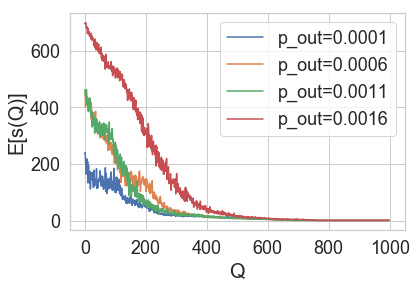

In [103]:
for w in tqdm_notebook(np.arange(0.0001,0.002,0.0005)):
    graph_params = {
      "graph_type": "gaussian_random_partition",
      "weight_scale": 0.3,
      "random_weight": 0,
      "n": 1000,
      "s": 15,
      "v": 0.3,
      "p_in": 0.05,
      "p_out": w
    }
    G = Generator(graph_params).get()

    ns_s = NetShieldSolver(G,k=len(G)) # TODO NetShield is for directed or not
    ns_s.run()
    all_Q = ns_s.log["Blocked nodes"]

    r = RobustWrapper.run_rob(G, all_Q, 5)

    plt.plot(r['sequence'], label="p_out={:0.4f}".format(w))
plt.legend()
plt.xlabel("Q")
plt.ylabel("E[s(Q)]")

### checking rim vs k

In [104]:
def run_adv_robustness(G, k):
    advs = {}
    K = k

    ns_s = NetShieldSolver(G,k=K)
    ns_s.run()
    advs["NetShield"] = ns_s.log["Blocked nodes"]

    deg_s = DegreeSolver(G,k=K)
    deg_s.run()
    advs["Degree"] = deg_s.log["Blocked nodes"]

    rn_s = RandomSolver(G,k=K)
    rn_s.run()
    advs["Random"] = rn_s.log["Blocked nodes"]

    single_greedy_result = RobustWrapper.run_satgreedy(G, epsilon=0.2,
                                                       number_of_seeds=1,
                                                       blocked_dic_of_nodes=advs,
                                                       beta=1, gamma=0.1, verbose=False)
    
    return single_greedy_result['satgreedy']['objective']

In [114]:
all_r = []
for m in tqdm_notebook(range(2,10,3)):
    graph_params = {
        "graph_type": "powerlaw_cluster",
        "weight_scale": 0.5,
        "both_directions": 0,
        "random_weight": 0,
        "n": 1000,
        "p": 0.4,
        "m": m
    }
    G = Generator(graph_params).get()

    r = []
    for k in tqdm_notebook(range(1,int(len(G)/3),10)):
        r.append((k, run_adv_robustness(G, k)))
    r = np.array(r)
    all_r.append(r)

Text(0, 0.5, 'RIM [Expected Spread]')

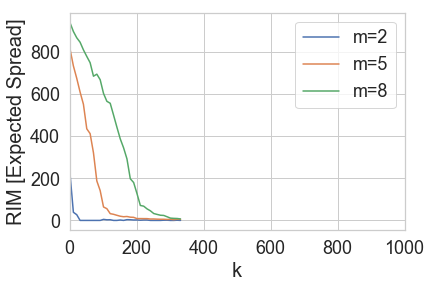

In [116]:
m = list(range(2,10,3))
i = 0
for r in all_r:
    plt.plot(r[:,0], r[:,1]*1000, label="m={}".format(m[i]))
    i+=1
plt.xlim((0,1000))
plt.legend()
plt.xlabel("k")
plt.ylabel("RIM [Expected Spread]")

In [25]:
results_all_imm = []
for i in range(0,10,3):
    results2 = []
    for p in tqdm_notebook(np.arange(0.1,1,0.1)):
        nx.set_edge_attributes(G,p,"weight")
        r = run_adv_robustness(G, i)
        results2.append((p,r))
    results2 = np.array(results2)
    results_all_imm.append(results2)

Text(0, 0.5, 'Expected number of nodes')

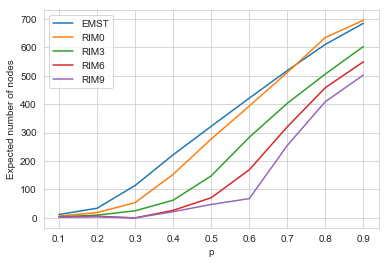

In [37]:
plt.plot(results[:,0],results[:,2],label="EMST")
j = 0
for i in range(0,10,3):
    plt.plot(results_all_imm[j][:,0],results_all_imm[j][:,1]*len(G),label="RIM{}".format(i))
    j += 1
plt.legend()
plt.xlabel("p")
plt.ylabel("Expected number of nodes")

In [41]:
# study generator parameters
results = []
for m in tqdm_notebook(range(1,30,5)):
    graph_params = {
        "graph_type": "powerlaw_cluster",
        "weight_scale": 0.3,
        "both_directions": 0,
        "random_weight": 0,
        "n": 1000,
        "p": 0.4,
        "m": m
    }
    G = Generator(graph_params).get()
    k = 10 # make random?
    rim = run_adv_robustness(G, k)
    
    ns_s = NetShieldSolver(G,k=len(G)) # TODO NetShield is for directed or not
    ns_s.run()
    all_Q = ns_s.log["Blocked nodes"]
    r = RobustWrapper.run_rob(G, all_Q, 5)
    
    results.append((m, rim, r['rob']))
results = np.array(results)

In [48]:
df = pd.DataFrame({'m': results[:,0], "RIM": results[:,1], "ESMT": results[:,2]})
pd.scatter_matrix(df, figsize=(6, 6))
plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

m number of edges correlates as parabola with RIM - robust influence maximization, and linearly with EBST - maximum tree in a graph. That means RIM with EBST do not correlate.

In [43]:
df.corr()

,m,EMST,RIM
m,1.000000,0.864056,0.990256
EMST,0.864056,1.000000,0.866133
RIM,0.990256,0.866133,1.000000


Perfect correlation of RIM with m??? m is number of edges

In [44]:
results = []
for m in tqdm_notebook(range(1,30,5)):
    graph_params = {
        "graph_type": "powerlaw_cluster",
        "weight_scale": 0.3,
        "both_directions": 0,
        "random_weight": 0,
        "n": 1000,
        "p": 0.4,
        "m": m
    }
    G = Generator(graph_params).get()
    k = 50 # make random?
    rim = run_adv_robustness(G, k)
    
#     ns_s = NetShieldSolver(G,k=len(G)) # TODO NetShield is for directed or not
#     ns_s.run()
#     all_Q = ns_s.log["Blocked nodes"]
#     r = RobustWrapper.run_rob(G, all_Q, 5)
    
    results.append((m, rim))
results = np.array(results)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


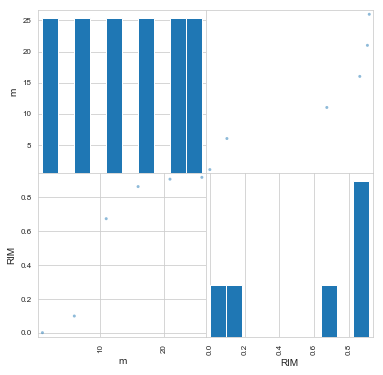

,m,RIM
m,1.000000,0.918835
RIM,0.918835,1.000000


In [45]:
df = pd.DataFrame({'m': results[:,0], "RIM": results[:,1]})
pd.scatter_matrix(df, figsize=(6, 6))
plt.show()
df.corr()

In [46]:
results = []
for m in tqdm_notebook(range(1,30,5)):
    graph_params = {
        "graph_type": "powerlaw_cluster",
        "weight_scale": 0.3,
        "both_directions": 0,
        "random_weight": 0,
        "n": 1000,
        "p": 0.4,
        "m": m
    }
    G = Generator(graph_params).get()
    k = 0 # make random?
    rim = run_adv_robustness(G, k)
    
#     ns_s = NetShieldSolver(G,k=len(G)) # TODO NetShield is for directed or not
#     ns_s.run()
#     all_Q = ns_s.log["Blocked nodes"]
#     r = RobustWrapper.run_rob(G, all_Q, 5)
    
    results.append((m, rim))
results = np.array(results)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


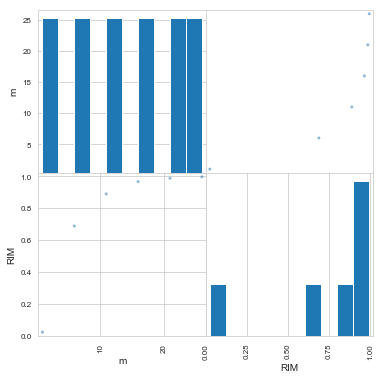

,m,RIM
m,1.000000,0.825358
RIM,0.825358,1.000000


In [47]:
df = pd.DataFrame({'m': results[:,0], "RIM": results[:,1]})
pd.scatter_matrix(df, figsize=(6, 6))
plt.show()
df.corr()

In [ ]:
# immunization against any of those types?
# random-random case? 